In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
metrics <- read_csv('../../data/task1/calibration/hetionet_calibration_metrics.csv')

metrics %>% head

Parsed with column specification:
cols(
  network = col_character(),
  metaedge = col_character(),
  feature = col_character(),
  cal = col_double(),
  ref = col_double(),
  brier = col_double(),
  weighted_mae = col_double(),
  auroc = col_double()
)


network,metaedge,feature,cal,ref,brier,weighted_mae,auroc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
full,AdG,xswap_prior,0.0005348332,0.007573513,0.008108346,0.3356053,0.9893918
full,AdG,analytic_prior,0.0006444262,0.007571256,0.008215682,0.3512889,0.9891555
full,AdG,scaled_degree,0.0015091243,0.007574097,0.009083222,0.4140236,0.9891437
full,AeG,xswap_prior,0.0011463458,0.018729566,0.019875912,0.1737322,0.9873503
full,AeG,analytic_prior,0.0045910898,0.018719604,0.023310694,0.2541119,0.9868655
full,AeG,scaled_degree,0.0195552381,0.018735534,0.038290772,0.3850257,0.9868530


In [3]:
metrics %>% tail(9)

network,metaedge,feature,cal,ref,brier,weighted_mae,auroc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
other,biorxiv,xswap_prior,2.442916e-05,0.002423209,0.002447638,0.4933140,0.7529958
other,biorxiv,analytic_prior,3.368862e-05,0.002416721,0.002450409,0.4944040,0.7792215
other,biorxiv,scaled_degree,2.197771e-04,0.002422244,0.002642021,0.4746879,0.7795811
other,ppi,xswap_prior,5.675853e-03,0.001546186,0.007222039,0.4998190,0.4954203
other,ppi,analytic_prior,3.209978e-01,0.001525104,0.322522950,0.5028672,0.4948885
other,ppi,scaled_degree,5.414115e-04,0.001534674,0.002076085,0.4999944,0.4949279
other,tftg,xswap_prior,1.665387e-02,0.118650473,0.135304347,0.4949403,0.5915009
other,tftg,analytic_prior,2.778197e-02,0.112168887,0.139950861,0.4993444,0.5961896
other,tftg,scaled_degree,2.377779e-02,0.114970419,0.138748212,0.4983514,0.5959106


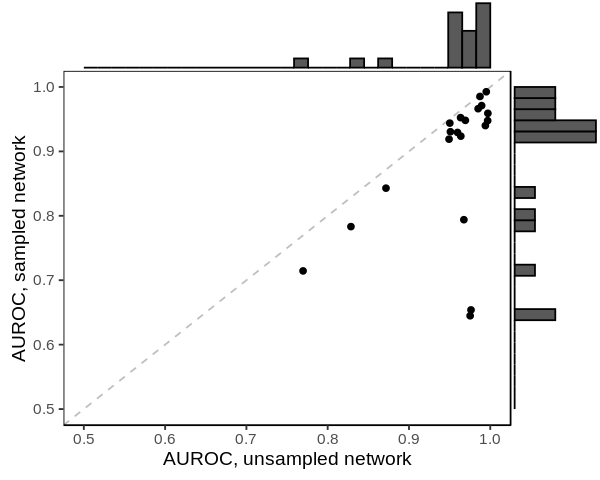

In [4]:
options(repr.plot.width=5, repr.plot.height=4)

auroc_plot <- metrics %>%
filter(feature == 'xswap_prior', network != 'other') %>%
select(metaedge, network, feature, auroc) %>%
mutate(network = network %>% recode_factor(full = "unsampled", sampled = "sampled")) %>%
spread(network, auroc) %>%
ggplot(aes(x = unsampled, y = sampled)) +
geom_abline(color = 'grey', linetype = 'dashed') +
geom_point() +
xlim(0.5, 1) +
ylim(0.5, 1) +
theme_zietzm() +
xlab('AUROC, unsampled network') +
ylab('AUROC, sampled network')

auroc_plot <- ggMarginal(auroc_plot, type = 'histogram', size = 5)
auroc_plot

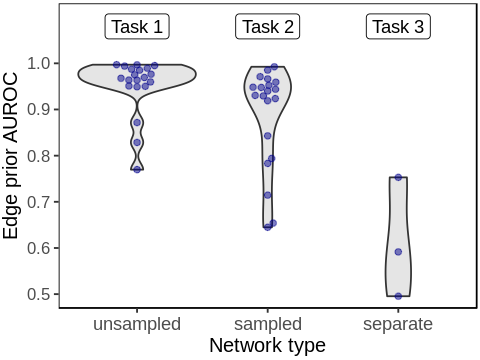

In [30]:
options(repr.plot.width=4, repr.plot.height=3)

auroc_tasks <- metrics %>%
filter(feature == 'xswap_prior') %>%
# mutate(network = network %>% factor(levels = c('full', 'sampled', 'other'))) %>%
mutate(network = network %>% recode_factor(full = "unsampled", sampled = 'sampled', other = 'separate')) %>%
ggplot(aes(x = network, y = auroc)) + 
# geom_boxplot(outlier.shape = NA) +
geom_violin(fill = 'grey90') +
geom_beeswarm(alpha = 0.5, color = 'darkblue', cex = 2.1) +
theme_zietzm() +
ylab('Edge prior AUROC') +
xlab('Network type') +
coord_cartesian(ylim = c(0.5, 1.1)) +
scale_y_continuous(breaks = c(0.5, 0.6, 0.7, 0.8, 0.9, 1.0)) +
geom_label(data = data.frame(network = c('unsampled', 'sampled', 'separate'), 
                             label = c('Task 1', 'Task 2', 'Task 3'),
                             auroc = rep(x = 1.08, times = 3)),
          aes(label = label)) +
theme(axis.title.x = element_text(size = 12), axis.title.y = element_text(size = 12), 
      axis.text.y = element_text(size = 10), axis.text.x = element_text(size = 11))

ggsave(filename = '../../img/auroc_dists.png', auroc_tasks, dpi = 300, width = 4, height = 3)

auroc_tasks